该脚本对GAN做进一步练习（实验），尝试使用GAN来重建cifar10　　
练习期间遇到一个重大的错误，或者说keras的一个小bug，即：

#### 练习时一直生成不出数字的主要原因：误将model_D设置成了untrainable!!!!!!!!!!!!!!!!!!!  
#### 从这个错误可以明显看出，keras模型model_D的trainable等属性在compile之后就定下来了。  
#### 虽然model_D依赖于net_D,而net_D的trainable属性在model_D compile之后发生了变化，但是compile时model_D已经被确定为  trainable.  
#### 可能keras 这里存在一个小的bug,查看model_D.summary()时会显示其参数untrainable

In [ ]:
from keras import Sequential
from keras.layers import Dense,Dropout,LeakyReLU,BatchNormalization,Conv2D,Flatten,Reshape,UpSampling2D
from keras.optimizers import RMSprop,Adam
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.datasets import cifar10

In [2]:
img_size=32
channel=3
input_shape=(img_size,img_size,channel)
dropout_prob=0.4

In [3]:
# def discriminator():
#     net = Sequential()
#     net.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',name='d_conv1',input_shape=input_shape)) #(14,14,64)
#     net.add(LeakyReLU())
#     net.add(Conv2D(filters=128,kernel_size=5,strides=2,padding='same',name='d_conv2')) #(7,7,128)
#     net.add(LeakyReLU())
#     net.add(Dropout(dropout_prob))
#     net.add(Conv2D(filters=256,kernel_size=5,strides=2,padding='same',name='d_conv3')) #(4,4,256)
#     net.add(LeakyReLU())
#     net.add(Dropout(dropout_prob))
#     net.add(Conv2D(filters=512,kernel_size=5,strides=1,padding='same',name='d_conv4')) #(4,4,512)
#     net.add(LeakyReLU())
#     net.add(Dropout(dropout_prob))
#     net.add(Flatten())
# #     net.add(Dense(units=1024,name='d_dense1'))
# #     net.add(LeakyReLU())
# #     net.add(Dropout(dropout_prob))
#     net.add(Dense(units=1,activation='sigmoid',name='d_dense2'))
#     return net
def discriminator():
    net = Sequential()
    net.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',name='d_conv1',input_shape=input_shape)) #(14,14,64)
    net.add(LeakyReLU())
    net.add(Conv2D(filters=128,kernel_size=5,strides=2,padding='same',name='d_conv2')) #(7,7,128)
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    net.add(Conv2D(filters=256,kernel_size=5,strides=2,padding='same',name='d_conv3')) #(4,4,256)
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob)) 
    net.add(Conv2D(filters=512,kernel_size=5,strides=1,padding='same',name='d_conv4')) #(4,4,512) 这一步stride是1
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    net.add(Flatten())
    net.add(Dense(units=1,activation='sigmoid'))
    return net

In [4]:
# def generator():
#     net = Sequential()
#     net.add(Dense(units=(7*7*128),input_dim=(100)))
#     net.add(BatchNormalization(momentum=0.9))
#     net.add(LeakyReLU())
#     net.add(Reshape((7,7,128)))
#     net.add(Dropout(dropout_prob))
#     net.add(UpSampling2D()) #(14,14,128)
#     net.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same',name='g_conv1')) #(14,14,64)
#     net.add(BatchNormalization(momentum=0.9))
#     net.add(LeakyReLU())
    
#     net.add(UpSampling2D())
#     net.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same',name='g_conv2')) #(28,28,32)
#     net.add(BatchNormalization(momentum=0.9))
#     net.add(LeakyReLU())
    
#     net.add(Conv2D(filters=1,kernel_size=5,strides=1,padding='same',activation='sigmoid',name='g_conv3')) #(28,28,1)
#     return net

In [5]:
def generator():
    net = Sequential()
    net.add(Dense(units=8*8*256,input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((8,8,256)))
    net.add(Dropout(dropout_prob))
    net.add(UpSampling2D()) #(14,14,256)
    net.add(Conv2D(filters=128,kernel_size=5,strides=1,padding='same')) #(14,14,128)
    net.add(BatchNormalization(momentum=0.9))  
    net.add(LeakyReLU())
    
    net.add(UpSampling2D()) #(28,28,128)
    net.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same')) #(28,28,64)
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())  
    
    net.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same')) #(28,28,32)
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(filters=3,kernel_size=5,strides=1,padding='same',activation='sigmoid')) #(28,28,1)
#     net.add(BatchNormalization(momentum=0.9))
    return net

In [6]:
net_D = discriminator()
net_G = generator()

In [7]:
net_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_conv1 (Conv2D)             (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
d_conv2 (Conv2D)             (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
d_conv3 (Conv2D)             (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

In [8]:
net_G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       819328    
__________

In [9]:
# optimizer_D=RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-10)
# model_D = Sequential()
# net_D = discriminator()
# model_D.add(net_D)
# model_D.compile(loss='binary_crossentropy',optimizer=optimizer_D,metrics = ['accuracy'])

# optimizer_A = Adam(lr=0.0004,clipvalue=1.0,decay=1e-10)
# model_A = Sequential()
# net_G = generator()
# model_A.add(net_G)
# for layer in net_D.layers:
#     layer.trainable=False
# #这样设置之后，model_D中的所有参数也变成不可以train了。如何解决？
# model_A.add(net_D)
# model_A.compile(loss='binary_crossentropy',optimizer=optimizer_A,metrics = ['accuracy'])

#### 练习时一直生成不出数字的主要原因：误将model_D设置成了untrainable!!!!!!!!!!!!!!!!!!!  
#### 从这个错误可以明显看出，keras模型model_D的trainable等属性在compile之后就定下来了。  
#### 虽然model_D依赖于net_D,而net_D的trainable属性在model_D compile之后发生了变化，但是compile时model_D已经被确定为  trainable.  
#### 可能keras 这里存在一个小的bug,查看model_D.summary()时会显示其参数untrainable

In [10]:
optimizer_D = RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-10)
optimizer_A = Adam(lr=0.0004,clipvalue=1.0,decay=1e-10)
model_D=Sequential()
model_A=Sequential()
model_D.add(net_D)
model_D.compile(loss='binary_crossentropy',optimizer=optimizer_D,metrics=['accuracy'])

model_A.add(net_G)
for layer in net_D.layers:
    layer.trainable=False
model_A.add(net_D)
# model_D.compile(loss='binary_crossentropy',optimizer=optimizer_D,metrics=['accuracy'])
#注意：错误犯在这里：误将model_D的compile步骤放在了freeze net_D之后。故model_D的参数真正变成了untrainable。
#可以通过后面的实验观察参数更新情况
model_A.compile(loss='binary_crossentropy',optimizer=optimizer_A,metrics=['accuracy'])

In [11]:
from keras.datasets import cifar10
(x_train,_),(x_test,_)=cifar10.load_data()
x_train=x_train.reshape((-1,img_size,img_size,channel))
x_train=x_train.astype('float')/255
m=x_train.shape[0]
Z = np.random.random(size=(m,100))
def get_random_batch(data,batch_size):
    random_ind = np.random.choice(m,batch_size,replace=True)
    return data[random_ind]

print(x_train.shape,Z.shape)

(50000, 32, 32, 3) (50000, 100)


In [12]:
x_train.shape

(50000, 32, 32, 3)

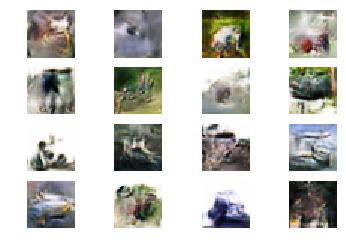

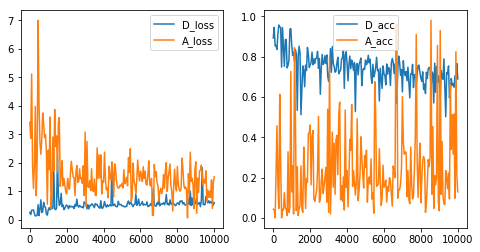

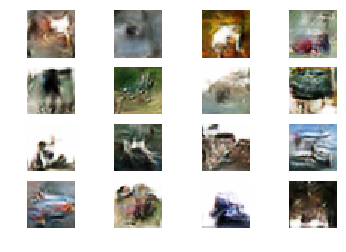

In [14]:
from IPython.display import clear_output
CHECK_WEIGHTS_UPDATE = 0

batch_size=256
viz_noise = np.random.random(size=(16,100))
D_loss=[]
D_acc=[]
A_loss=[]
A_acc=[]
plot_iteration=[]
for i in range(10001):
    real_batch = get_random_batch(x_train,batch_size)
    noise_batch = get_random_batch(Z,batch_size)
    fake_batch = net_G.predict(noise_batch)
    x = np.concatenate((real_batch,fake_batch))
    y=np.ones((batch_size*2,1))
#     y[:batch_size,0]=0 #标签写反了.导致训练结果错误：model_A对所有z的输出均非常接近0.5,net_G生成的结果很差
    y[batch_size:,0]=0
    D_state = model_D.train_on_batch(x,y)
    
    x = get_random_batch(Z,batch_size)
    y=np.ones((batch_size,1))
    A_state = model_A.train_on_batch(x,y)
    if i%50==0:
        if CHECK_WEIGHTS_UPDATE:
            w_d_in_D=model_D.layers[-1].get_weights()[0][0][0][0][:5]
            w_d_in_A=model_A.layers[-1].get_weights()[0][0][0][0][:5]
            print('iter: {0} 判别器最后一层参数: {1}'.format(i,w_d_in_D)) #显示model_D中的判别器参数更新情况
            print('iter: {0} 对抗模型最后一层参数: {1}'.format(i,w_d_in_A)) #显示model_A中的判别器参数更新情况
        else:
            #打印出model_D中的某五个参数，观察其是否更新
            clear_output(wait=True)
    #         D_loss.append(D_state.history['loss'])
    #         A_loss.append(A_state.history['loss'])
    #         D_acc.append(D_state.history['acc'])
    #         A_acc.append(A_state.history['acc'])
            D_loss.append(D_state[0])
            A_loss.append(A_state[0])
            D_acc.append(D_state[1])
            A_acc.append(A_state[1])
            plot_iteration.append(i)
            fig,(ax1,ax2)=plt.subplots(1,2)
            fig.set_size_inches(8,4)
            ax1.plot(plot_iteration,D_loss,label='D_loss')
            ax1.plot(plot_iteration,A_loss,label='A_loss')
            ax2.plot(plot_iteration,D_acc,label='D_acc')
            ax2.plot(plot_iteration,A_acc,label='A_acc')
            ax1.legend()
            ax2.legend()
            plt.show()

            images=net_G.predict(viz_noise)
            for im in range(images.shape[0]):
                plt.subplot(4,4,im+1)
                plt.imshow(np.squeeze(images[im]),cmap='gray')
                plt.axis('off')
#             plt.tight_layout()
#             plt.savefig(r'output/test_GAN/{}.png'.format(i))
#             plt.close('all')

In [ ]:
def plot_generated_image(g):
    plt.imshow(np.squeeze(g),cmap='gray')

In [ ]:
z1 = np.random.random((1,100))
plot_generated_image(net_G.predict(z1))
model_A.predict(z1)

In [ ]:
fake_batch.shape

In [ ]:
real_batch.shape